### Week4_文件分類

此 Jupyter Notebook 為教學「文件分類」。<br>
主要使用文章轉DTM的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用SVM、linear regression等方式訓練模型，以分辨不同的文件。<br>

下面將展示「英文」的文件分類，使用 Jane austen 的 pride and prejudice，與 H. G. Wells 的 the war of the worlds 做示範。

### 套件說明
下面列出在本次實作過程中所使用到的相關套件。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- sklearn: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- seaborn: 基於 matplotlib 封裝的繪圖工具
- time: 獲得目前的時間或作時間格式轉換的工具

In [1]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, pipeline, metrics, svm, ensemble
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import time

請讀取提供的資料：「books.csv」<br>
裡面為兩本書的斷詞結果 concat 起來的資料，前面為 The war of the Worlds，後面為 Pride and Prejudice。<br>
<br>
資料欄位說明：<br>
+ sentence : 清除過停用字的斷句結果
+ title : 書名

,sentence,title
0,war worlds,The war of the Worlds
1,h g wells,The war of the Worlds
2,shall dwell worlds inhabited,The war of the Worlds
3,lords world,The war of the Worlds
4,things made man,The war of the Worlds
...,...,...
14633,visits uncle aunt city,Pride and Prejudice
14634,gardiners always intimate terms darcy,Pride and Prejudice
14635,well elizabeth really loved ever,Pride and Prejudice
14636,sensible warmest gratitude towards persons bri...,Pride and Prejudice


簡單的看一下兩本書各有多少個句子，發現兩本書的句子大概差了兩倍

Pride and Prejudice      9069
The war of the Worlds    5569
Name: title, dtype: int64

#### 將資料分為測試集與訓練集
通常訓練模型時，會依照 7:3 的比例，將資料及切為「訓練集」與「測試集」。<br>
這邊可以利用 sklearn 中的 train_test_split function 將資料隨機切成 7:3。<br>
`記得要設定 random_state ，這樣每次切割的結果才會一致。`

看一下兩本書的比例。<br>
用這個方式切出來的比例會跟 raw_data 的比例差不多。

raw data percentage :
Pride and Prejudice      61.955185
The war of the Worlds    38.044815
Name: title, dtype: float64

train percentage :
Pride and Prejudice      61.955885
The war of the Worlds    38.044115
Name: title, dtype: float64

test percentage :
Pride and Prejudice      61.953552
The war of the Worlds    38.046448
Name: title, dtype: float64


#### 將文章轉為 DTM 放入模型訓練
DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法，這邊用兩個不同的方法來比較。
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

#### 簡單練習 DTM
先用簡單幾句英文建立 DTM ，這裡利用 CountVectorizer 計算出不同句子的詞頻，再轉換成DTM。<br>
DTM 每一個 row 代表一個句子，每個 column 代表一個詞出現的次數。<br>

CountVectorizer 裡面有參數可以設定
+ ngram_range : 句子要考慮前後幾個字（unigram、bigram...
+ max_features : 取 詞頻 / tfidf 前多少的字
+ min_df : 篩選出現次數大於n的字，或是可以設定比例

下面的簡單範例可以先用 unigram 及 參數預設來做練習。<br>
後面實際分類書籍時，請自行設定，不同的參數可能會造成準確度上升或下降。

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.'
]

# 轉成dataframe來看


# DTM 字詞可以藉由 get_feature_names 查看

# DTM的資料結構，裡面代表字詞的頻率



documents: 3 terms: 9

terms:
 ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

DTM array:
 [[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]]


,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,2,0,1,0,1,1,0,1
2,1,0,0,1,1,0,1,1,1


#### 套入資料集訓練
三個模型：Logistic regression、Random Forest、SVC
+ Logistic regression : [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
+ Random Forest : [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
+ SVC : [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

放入 DTM 的值為上述所說的：詞頻、TF-IDF
+ 依據詞頻 (CountVectorizer) : [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 依據 tfidf : [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

所以總共會有六個結果：
+ Logistic regression + cv
+ Logistic regression + TF-IDF
+ Random Forest + cv
+ Random Forest + TF-IDF
+ SVC + cv
+ SVC + TF-IDF

仿照剛剛簡單實作 DTM 的方式，來建立書籍模型的 DTM。<br>
因此 corpus 的地方要換為 training data 的 sentence (也就是訓練句子)。<br>
這邊先建立 CountVectorizer。

In [7]:
# # Count (classic BoW)


可以根據 CountVectorizer 的 method 來看 X_train 的 shape。<br>
假如有設定 min_df，維度就會長得不一樣。<br>
下面的範例結果有設定 max_features=10000、min_df=10

posts: 10246 
words: 1227 


CountVectorizer 的建完，來建立 TfidfVectorizer 的 DTM。<br>
而 TfidfVectorizer 跟 CountVectorizer 一樣，也有參數可以設定。<br>
下面的範例結果為設定 max_features=100、ngram_range=(1,2)

In [9]:
# Tf-Idf (advanced variant of BoW)


將文章轉為 DTM 後，我們要把它放進模型做訓練。<br>
因為後面總共會用到三個不同訓練方式，所以將建模的過程包成 function 會比較方便使用。<br>
但在包成 function 之前，先用 logistic regressin + cv tokenizer 簡單示範一次建模過程。

定義模型的訓練組合可以使用 [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)<br>
pipeline 的方法除了可以方便定義分類模型及處理好的資料集，可以直接使用他的 fit 與 predict method ，來對模型進行訓練與預測。

In [10]:
# 先定義 classifier


# 再定義model --> pipeline: 分類器 + 資料處理 vectorizer


# 接著，把 train data 跟 test data 的 label 拿出來


# 放入 train data 的 x & y(label) 訓練 model


# 測試 test data


用以下幾個指標來顯示預測的結果：
+ Accuracy、Precision、Recall
+ Confusion matrix
+ ROC curve

Accuracy: 0.88
Auc: 0.95
Detail:
                       precision    recall  f1-score   support

  Pride and Prejudice       0.90      0.90      0.90      2721
The war of the Worlds       0.84      0.84      0.84      1671

             accuracy                           0.88      4392
            macro avg       0.87      0.87      0.87      4392
         weighted avg       0.88      0.88      0.88      4392



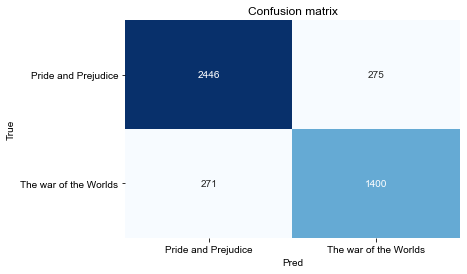

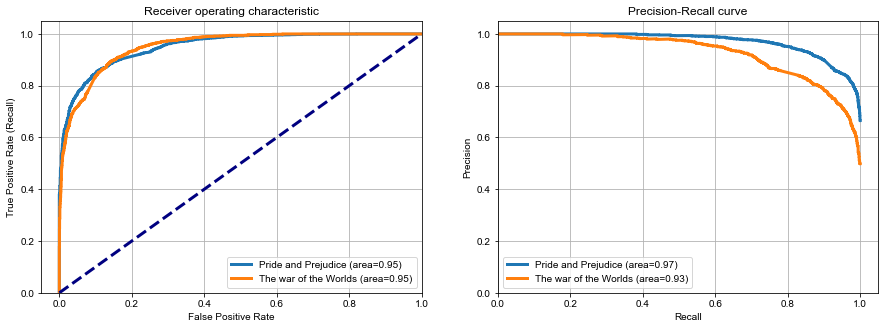

In [11]:
# Accuracy --> metrics.accuracy_score


# AUC (Area Under Curve) --> metrics.roc_auc_score


# Detail (Precision, Recall, F1-score ... etc) --> metrics.classification_report

    
# Plot confusion matrix --> metrics.confusion_matrix


# Plot roc --> metrics.roc_curve

    
## Plot precision-recall curve


因為總共有六結果要顯示，所以請將上述的建模與畫圖的步驟包成 function，在程式實作上會簡潔很多。

In [12]:
# model & predict function


In [13]:
# evaluate function


將 function 包好後，定義 vectorizer 與 classifier 。

In [14]:
# 定義 CountVectorizer & TfidfVectorizer

# 定義 classifier : Logistic Regression、SVC、Random Forest


接著定義 train data & test data

因為後面需要做模型比較，因此創造一個空的 dataframe 和 list 存模型結果。

#### 比較不同模型和資料組合的訓練結果

### Logistic regression

model type: CV + logistic regression
Accuracy: 0.88
Auc: 0.95
Detail:
                       precision    recall  f1-score   support

  Pride and Prejudice       0.90      0.90      0.90      2721
The war of the Worlds       0.84      0.84      0.84      1671

             accuracy                           0.88      4392
            macro avg       0.87      0.87      0.87      4392
         weighted avg       0.88      0.88      0.88      4392



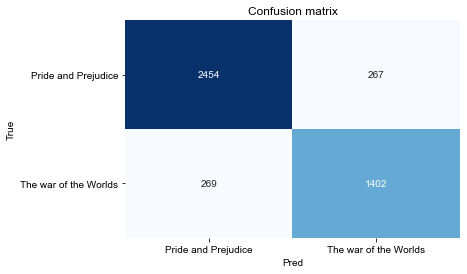

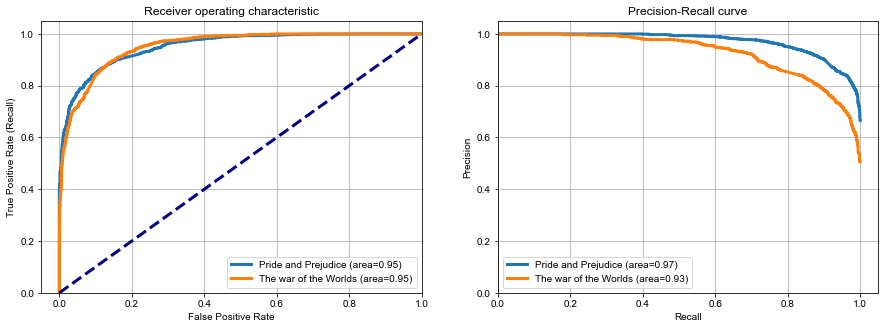

In [17]:
# print model type


# 訓練模型


# 查看模型訓練結果


# 把結果加進result_df


model type: TF-IDF + logistic regression
Accuracy: 0.87
Auc: 0.95
Detail:
                       precision    recall  f1-score   support

  Pride and Prejudice       0.86      0.93      0.90      2721
The war of the Worlds       0.87      0.76      0.81      1671

             accuracy                           0.87      4392
            macro avg       0.87      0.85      0.85      4392
         weighted avg       0.87      0.87      0.86      4392



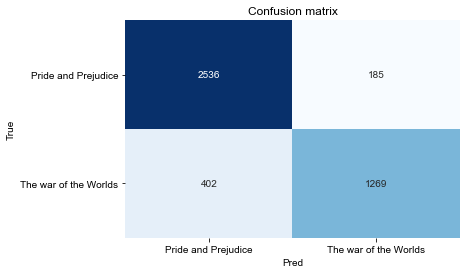

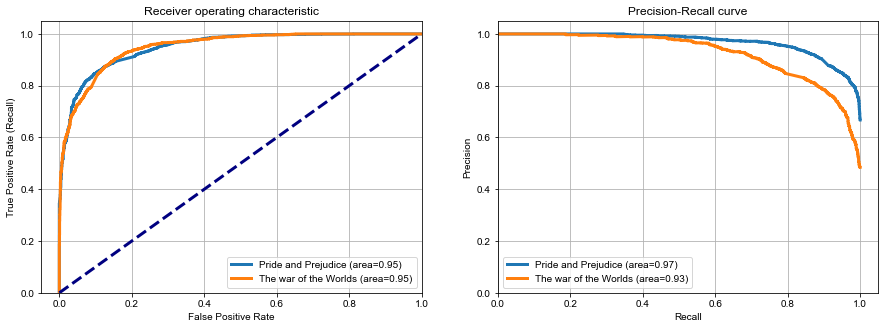

In [18]:
# print model type


# 訓練模型


# 查看模型訓練結果


# 把結果加進result_df



### SVC（這裡會需要較長的時間）

model type: CV + SVC
Accuracy: 0.87
Auc: 0.94
Detail:
                       precision    recall  f1-score   support

  Pride and Prejudice       0.90      0.90      0.90      2721
The war of the Worlds       0.84      0.83      0.83      1671

             accuracy                           0.87      4392
            macro avg       0.87      0.86      0.87      4392
         weighted avg       0.87      0.87      0.87      4392



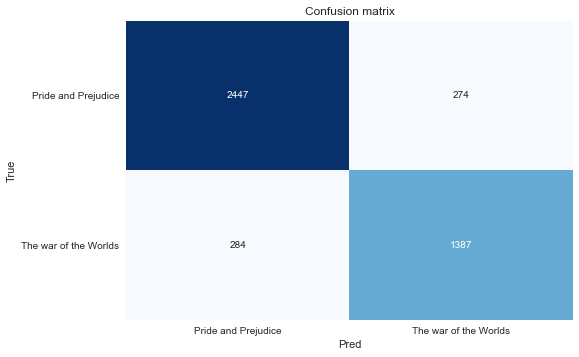

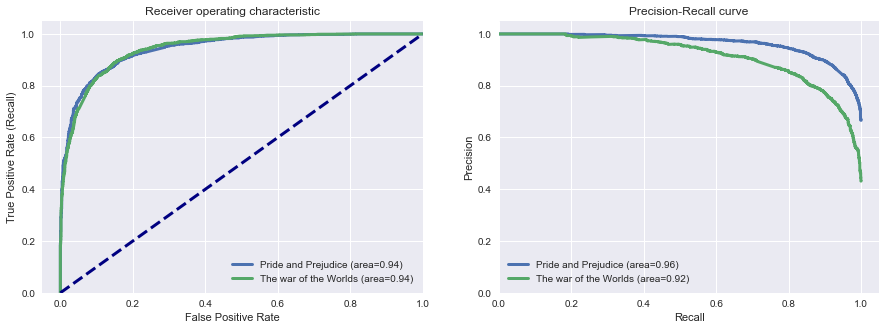

In [27]:
# print model type


# 訓練模型


# 查看模型訓練結果


# 把結果加進result_df



model type: TF-IDF + SVC
Accuracy: 0.87
Auc: 0.94
Detail:
                       precision    recall  f1-score   support

  Pride and Prejudice       0.89      0.91      0.90      2721
The war of the Worlds       0.85      0.81      0.83      1671

             accuracy                           0.87      4392
            macro avg       0.87      0.86      0.87      4392
         weighted avg       0.87      0.87      0.87      4392



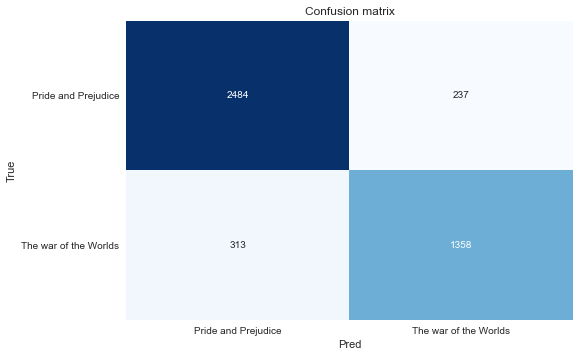

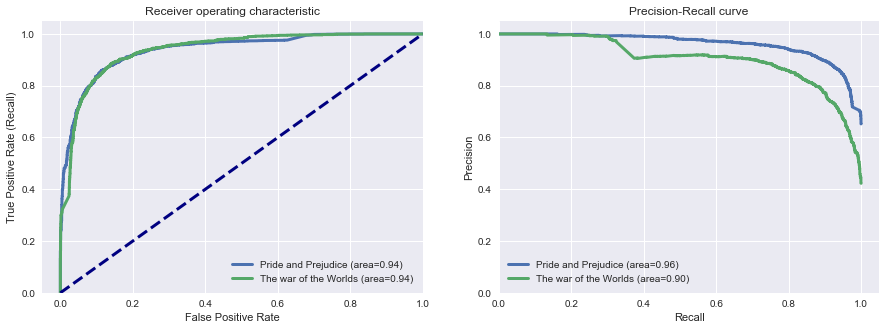

In [26]:
# print model type


# 訓練模型


# 查看模型訓練結果


# 把結果加進result_df



### RandomForest

model type: CV + RandomForest
Accuracy: 0.84
Auc: 0.92
Detail:
                       precision    recall  f1-score   support

  Pride and Prejudice       0.89      0.85      0.87      2721
The war of the Worlds       0.78      0.83      0.80      1671

             accuracy                           0.84      4392
            macro avg       0.83      0.84      0.84      4392
         weighted avg       0.85      0.84      0.85      4392



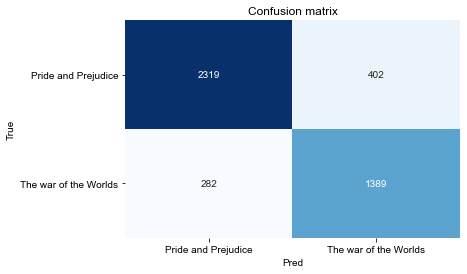

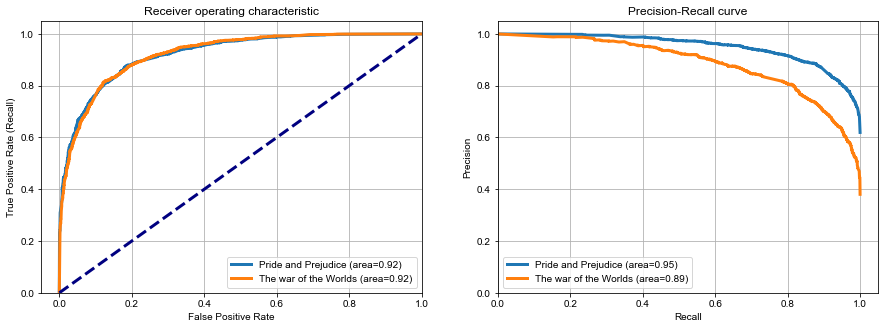

In [21]:
# print model type


# 訓練模型


# 查看模型訓練結果



# 把結果加進result_df



model type: TF-IDF + RandomForest
Accuracy: 0.84
Auc: 0.92
Detail:
                       precision    recall  f1-score   support

  Pride and Prejudice       0.88      0.86      0.87      2721
The war of the Worlds       0.78      0.81      0.80      1671

             accuracy                           0.84      4392
            macro avg       0.83      0.84      0.83      4392
         weighted avg       0.84      0.84      0.84      4392



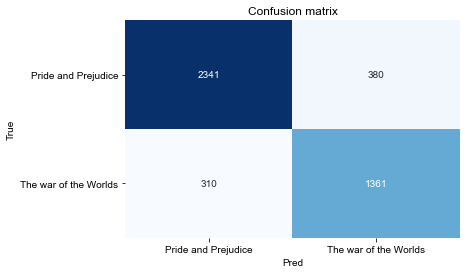

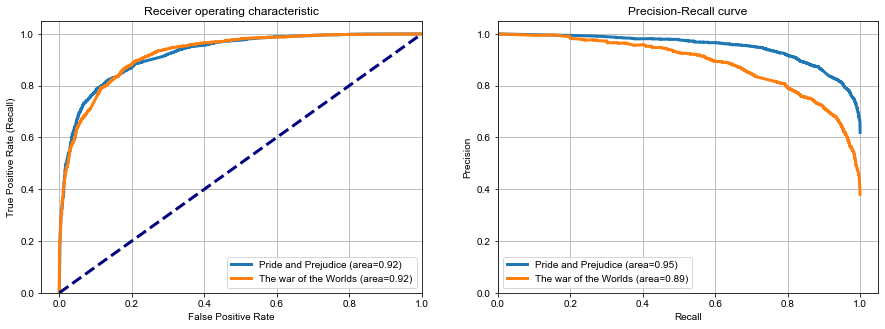

In [22]:
# print model type


# 訓練模型


# 查看模型訓練結果


# 把結果加進result_df



最後將上面模型的結果做比較。

In [23]:
# AUC、Accuracy


,model_type,Accuracy,AUC
0,CV + logistic regression,0.877960,0.951507
3,TF-IDF + SVC,0.874772,0.937691
2,CV + SVC,0.872951,0.943898
1,TF-IDF + logistic regression,0.866348,0.949152
4,CV + RandomForest,0.844262,0.922653
5,TF-IDF + RandomForest,0.842896,0.923082


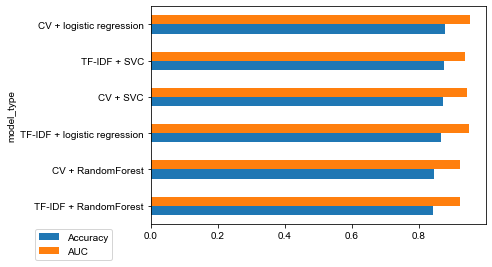

In [24]:
# 將 AUC、Accuracy 化成長條圖做比較


將 ROC curve 放在一起做比較（Pride and Prejudice）

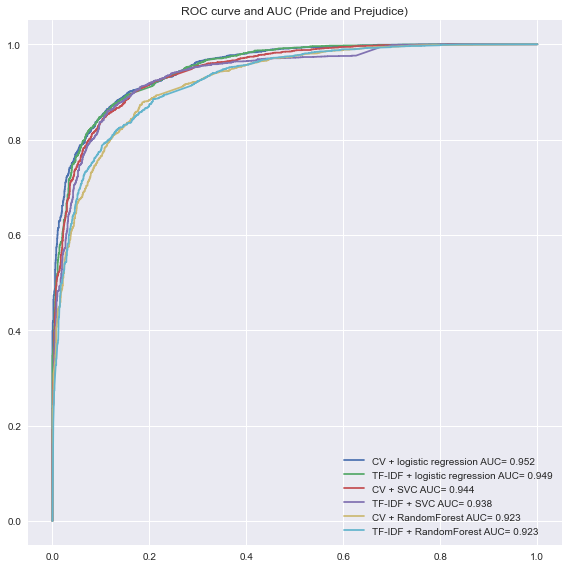